In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import multivariate_normal


import gpflow
import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf

import pickle

from splitgpm import SplitGPM, normalize
import gpflow.training.monitor as mon
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from splitgpm import SplitGPM
from Assignments import Assignments
from utils import gen_gsea_df

### Set number of clusters

Set K1, and K2 to what you want.

In [4]:
K1 = 2  # cell clusters
K2 = 20  # gene clusters

### Load data

In [5]:
# load data
file_path='../gplvm/data/ipsc_expression_data/quantile_normalized_no_projection.txt'
data = pd.read_csv(file_path, delim_whitespace=True, index_col=0)

In [6]:
# filter down to genes with hgnc gene names
ensembl_to_gene_name = pd.read_csv('ensembl_gene_name')
has_gene_name = ~(ensembl_to_gene_name.hgnc_symbol.values.astype(str) == 'nan')
ensembl_to_gene_name = ensembl_to_gene_name[has_gene_name]

active_genes = np.isin(data.index.values, ensembl_to_gene_name.ensembl_gene_id.values)
data = data[active_genes]

In [7]:
# normalize expression, reshape data
normalized_data = (data.values - data.values.mean(1)[:, None]) / data.values.std(1)[:, None]
data.iloc[:, :] = normalized_data
data = pd.melt(data.reset_index(), id_vars='Gene_id')

split_labels = data.variable.apply(lambda x: str(x).split('_'))
labels_df = pd.DataFrame([x for x in split_labels.values], columns=['line', 'time'])

data = pd.concat([labels_df, data], axis=1)
data = data.drop('variable', 1)

In [8]:
# set up data for model
X = data.time.values.astype(np.float64)[:, None]
Y = data.value.values.astype(np.float64)[:, None]

genes, W2_idx = np.unique(data.Gene_id, return_inverse=True)
cell_lines, W1_idx = np.unique(data.line, return_inverse=True)

Z = np.unique(data.time.astype(np.float64))[:, None]

In [9]:
# This is what we will pass as input to SplitGPM
X_aug = np.concatenate([X, W1_idx[:, None], W2_idx[:, None]], axis=1)

### Initialize the model

We need to initialize W1 and W2, which are [N, K1], [G, K2] respectively and hold the estimated probability that a cell belongs to a given cell cluster, or a gene belongs to a give gene cluster repsectively. Here they are initialized randomly, but a better choice can probably be made.

When we call the constructor we pass the following arguments
- X
- Y
- logW1 the log assignment weights for cells to cell clusters (add a small constant to prevent log(0)) [N, K1]
- logW2 thel log assignment probability for genes to gene clusters [G, K2]
- a gplfow multioutput kernel object, this controls how the functions we estimate behave. We use and RBF kernel here which generates smooth function
- a gpflow multioutput feature object, this holds the inducing points-- a set of points that we are going to summarize our data at
- minibatch size: if we have a lot of data we will need to subsample to make it tractable
- name: a name for the model to keep things neat with tensorflow

In [10]:
def normalize(X):
    return X / X.sum(1)[:, None]

In [11]:
gpflow.reset_default_graph_and_session()
name = 'test'
minibatch_size = 500

N = cell_lines.size
G = genes.size

np.random.seed(42)  # fix random initialization
W1_init = normalize(np.random.random(size=(N, K1)))
W2_init = normalize(np.random.random(size=(G, K2)))


with gpflow.defer_build():
    kernel = mk.SharedIndependentMok(gpflow.kernels.RBF(1, active_dims=[0]), K1 * K2)
    Z = np.linspace(0, 15, 16)[:, None].astype(np.float64)
    feature = gpflow.features.InducingPoints(Z)
    feature = mf.SharedIndependentMof(feature)

    model = SplitGPM(X_aug, Y,
                   np.log(W1_init + 1e-5), np.log(W2_init + 1e-5),
                   kernel, gpflow.likelihoods.Gaussian(),
                   feat=feature,
                   minibatch_size=minibatch_size,
                   name=name)
model.compile()

W0807 11:31:14.077245 4597626304 deprecation.py:323] From /Users/karltayeb/anaconda3/lib/python3.7/site-packages/gpflow/params/dataholders.py:223: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


### What parts of the model do you want to train?

We dont train the features since we have an inducing point for every unique input

In [12]:
model.W1.set_trainable(True)  # learn cell assignments
model.W2.set_trainable(True)  # learn gene assignments
model.feature.set_trainable(False)  # move inducing points
model.kern.set_trainable(True)  # learn kernel parameters
model.likelihood.set_trainable(True)  # lear likelihood parameters

### Train the model

All we are doing here is gradient based optimization of the objective. There are closed form updates for a lot of the parameters we are estimating here if we stick with Gaussian noise. In particular we CAN do gradient ascent on W1, W2, q_mu, and q_var. The only thing we are actually stuck using gradient based optimization for are the inducingBut gradient based optimization seems to learn decent representations and the closed form updates in this implementation arent tested yet.

In [13]:
adam = gpflow.train.AdamOptimizer(0.005)
adam.minimize(model, maxiter=30000)

W0807 11:31:25.500303 4597626304 deprecation.py:323] From /Users/karltayeb/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_grad.py:425: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0807 11:31:25.912585 4597626304 deprecation.py:506] From /Users/karltayeb/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Make a plot

Here we can plot the trajectories learned for each cluster. Notice here that it didnt actually learn trajectories that look very much like the sinusoidal functions used to generate the data.

We are prone to these sorts of local optima when we do not know how observations in different parts of the domain are related to one another-- if we had observations throughout the input space that we know belong to the same cluster (this information would be encoded in the index columns of X)

Notice also that it learned a solution with an empty gene cluster-- we can escape these types of local optima by resetting those clusters until something sticks to it

In [14]:
Xnew = np.linspace(0, 15, 100)[:, None]
mu, var = model.predict_f(Xnew)

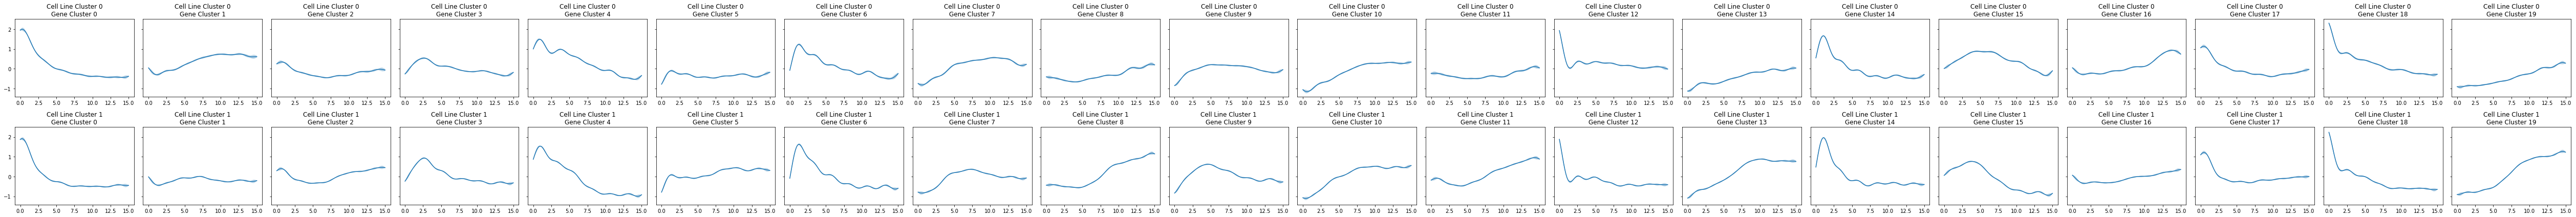

In [36]:
fig, ax = plt.subplots(K1, K2, figsize=(K2 * 3.5, K1 * 3), sharey=True)

mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T

a1 = model.W1.value.argmax(1)[X_aug[:, 1].astype(int)]
a2 = model.W2.value.argmax(1)[X_aug[:, 2].astype(int)]
for k in range(K1):
    for l in range(K2):
        ax[k, l].plot(Xnew, mu[:, l, k])
        ax[k, l].fill_between(
            Xnew.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)
        ax[k, l].set_title('Cell Line Cluster {}\nGene Cluster {}'.format(k, l))
plt.tight_layout()

### A note

Using gradient based optimization tends to find a 6/13 split of the cell lines. Nonetheless the gene clusters found show similar trajectories and enrichments with GO-BP.

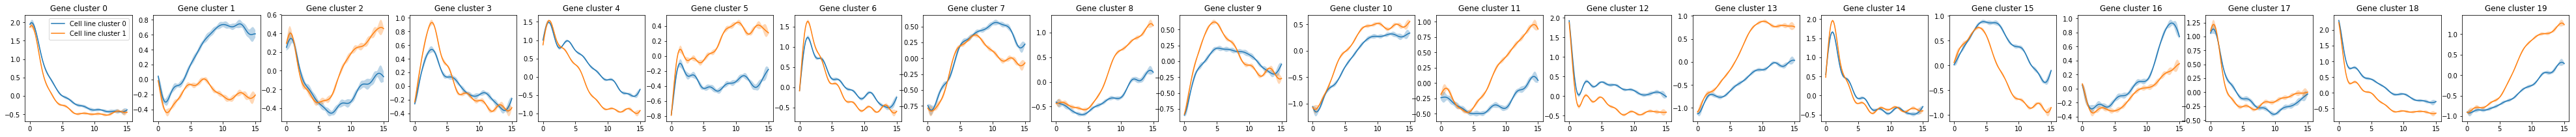

In [41]:
fig, ax = plt.subplots(1, K2, figsize=(K2 * 3.5, 3))

mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T

a1 = model.W1.value.argmax(1)[X_aug[:, 1].astype(int)]
a2 = model.W2.value.argmax(1)[X_aug[:, 2].astype(int)]
for k in range(K1):
    for l in range(K2):
        ax[l].plot(Xnew, mu[:, l, k], label='Cell line cluster {}'.format(k))
        ax[l].fill_between(
            Xnew.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)
        ax[l].set_title('Gene cluster {}'.format(l))

ax[0].legend()

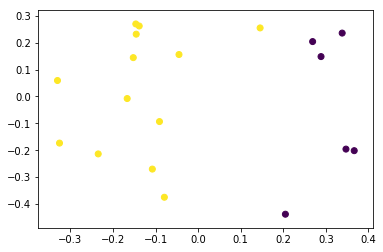

In [38]:
def pcplot(model):
    Z = data.set_index(['Gene_id', 'time']).pivot(columns='line').values
    Z = Z - np.nanmean(Z, 1)[:, None]
    Z = Z / np.nanstd(Z, 1)[:, None]
    u,s,vh = np.linalg.svd(np.nan_to_num(Z.T), full_matrices=False)

    pc1 = np.squeeze(np.asarray(u[:,0]))
    pc2 = np.squeeze(np.asarray(u[:,1]))
    pc3 = np.squeeze(np.asarray(u[:,3]))
    pc4 = np.squeeze(np.asarray(u[:,4]))
    
    plt.scatter(pc1, pc2, c=model.W1.value.argmax(1))
    
pcplot(model)

In [39]:
assignments = model.W2.value.argmax(1)
results = gen_gsea_df(assignments, ensembl_to_gene_name.hgnc_symbol.values, 'gsea_output', threshold=1e-2, rerun=True)

In [40]:
idx = pd.IndexSlice
active_clusters = np.where(np.any(results.T.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=0) == 1)[0]
active_results = pd.concat([results.T.iloc[:, results.index.get_level_values(0).get_loc(a)] for a in active_clusters], axis=1)
active_gene_sets = np.where(np.any(active_results.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=1))[0]
active_results = active_results.iloc[active_gene_sets]
active_results.loc[:, idx[:, 'bonferonni-adjusted']]

,0,2,4,6,8,10,11,12,14,15,16,19
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
HALLMARK_MITOTIC_SPINDLE,1,1,0.00119739,1,1,0.00353595,1,1,1,0.00160484,1,1
HALLMARK_DNA_REPAIR,1,1,0.00114294,0.334112,1,1,1,1,0.405423,1,1,1
HALLMARK_G2M_CHECKPOINT,1,1,7.55071e-33,1,1,1,1,1,1,1.49457e-16,1,1
HALLMARK_MYOGENESIS,1,1,1,1,0.000206936,1,0.00300759,1,1,1,1,1.73205e-13
HALLMARK_INTERFERON_GAMMA_RESPONSE,0.258298,1,1,1,1,1,1,1,0.00410304,1,1,1
HALLMARK_APICAL_JUNCTION,1,1,1,1,1,1,1,0.00949067,1,1,1,1
HALLMARK_COMPLEMENT,1,1,1,1,1,1,1,1,1,1,0.00397331,1
HALLMARK_MTORC1_SIGNALING,1,1,0.00163996,1,1,1,1,1,6.50694e-05,1,1,1
HALLMARK_E2F_TARGETS,1,1,7.0999e-61,1,1,1,1,1,1,1.55156e-13,1,1
